In [1]:
####
# Statistics:
# average time difference between adjacent node
# time difference between source tweet and its first response
# post time distribution
####

In [2]:
import os
from os import path
import json
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

In [3]:
NEWS_DIR = "../../fakenewsnet_dataset/politifact/fake"

In [14]:
# convert month string to number
def month_str_to_num(month_string):
    month_dict = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }

    if month_string in month_dict:
        return month_dict[month_string]
    else:
        return -1

def get_post_datetime(datatime_str):

    # example of date string: "Fri Dec 08 17:08:28 +0000 2017"

    datetime_slices = datatime_str.split(" ")

    year = int(datetime_slices[5])
    month = month_str_to_num(datetime_slices[1])
    assert month >= 1
    day = int(datetime_slices[2])
    hour = int(datetime_slices[3].split(":")[0])
    minute = int(datetime_slices[3].split(":")[1])
    second = int(datetime_slices[3].split(":")[2])

    return datetime(year, month, day, hour, minute, second)

def time_diff_in_minute(t1, t2):
    return (t2-t1).seconds / 60

def time_diff_in_days(t1, t2):
    return (t2 - t1).days

def cascade_time_diffs(root_node):

    diffs = []
    children = [] + root_node["quoted_by"] + root_node["replied_by"] + root_node["retweeted_by"]
    for child in children:
        t1 = get_post_datetime(root_node['created_at'])
        t2 = get_post_datetime(child['created_at'])
        diffs.append(time_diff_in_minute(t1, t2))
        diffs += cascade_time_diffs(child)

    return diffs

def cascade_first_time_diff(root_node):

    diffs = []
    children = [] + root_node["quoted_by"] + root_node["replied_by"] + root_node["retweeted_by"]
    for child in children:
        t1 = get_post_datetime(root_node['created_at'])
        t2 = get_post_datetime(child['created_at'])
        diffs.append(time_diff_in_minute(t1, t2))

    if len(diffs) > 0:
        return min(diffs)
    else:
        return -1

def tree_size(root_node):

    node_count  = 1 # itself

    children = [] + root_node["quoted_by"] + root_node["replied_by"] + root_node["retweeted_by"]
    for child in children:
        node_count += tree_size(child)

    return node_count

def cascade_post_times(root_node, first_datetime):
    diff_to_root = []

    children = [] + root_node["quoted_by"] + root_node["replied_by"] + root_node["retweeted_by"]
    for child in children:
        child_datetime = get_post_datetime(child['created_at'])
        diff_to_root.append(time_diff_in_minute(first_datetime, child_datetime))

    for child in children:
        diff_to_root += cascade_post_times(child, first_datetime)

    return diff_to_root

In [12]:
def cascade_latest_datetime(root_node):
    
    latest = get_post_datetime(root_node['created_at'])
    
    children = [] + root_node["quoted_by"] + root_node["replied_by"] + root_node["retweeted_by"]
    for child in children:
        child_latest = cascade_latest_datetime(child)
        latest = max(latest, child_latest)
        
    return latest

In [15]:
news_count = 0

sizes = []
average_time_diffs = []
first_time_diffs = []
time_distributions = []
lifespans = []
for item in os.listdir(NEWS_DIR):
    news_dir_path = path.abspath( path.join(NEWS_DIR, item) )
    
    if path.isdir(news_dir_path):

        if not path.exists(f"{news_dir_path}/news content.json"):
            continue

        if not path.exists(f"{news_dir_path}/cascade.json"):
            continue

        news_count += 1
        # if news_count > 10:
        #     break

        with open(f"{news_dir_path}/cascade.json", "r") as cascade_file:
            cascades = json.loads(cascade_file.read())

            for cas in cascades:
                cascade_size = tree_size(cas)
                sizes.append(cascade_size)
                time_diffs = np.array(cascade_time_diffs(cas))
                if len(time_diffs) > 0:
                    average_time_diffs.append(time_diffs.mean().item())
                else:
                    average_time_diffs.append(-1)
                first_time_diffs.append(cascade_first_time_diff(cas))

                if cascade_size > 1:
                    post_times = sorted(cascade_post_times(cas, get_post_datetime(cas['created_at'])))
                    time_distributions.append(post_times)
                else:
                    time_distributions.append([])
                    
                cascade_latest = cascade_latest_datetime(cas)
                lifespan = time_diff_in_days(get_post_datetime(cas['created_at']), cascade_latest)
                lifespans.append(lifespan)

In [19]:
sizes = np.array(sizes)
average_time_diffs = np.array(average_time_diffs)
first_time_diffs = np.array(first_time_diffs)
lifespans = np.array(lifespans)

avg_t_diffs = average_time_diffs[average_time_diffs != -1]
fir_t_diffs = first_time_diffs[first_time_diffs != -1]

In [20]:
print(f"average time difference b/t adjacent nodes: min={avg_t_diffs.min()}, max={avg_t_diffs.max()}, mean={avg_t_diffs.mean()}, median={np.median(avg_t_diffs)}")
print(f"time difference of first response: min={fir_t_diffs.min()}, max={fir_t_diffs.max()}, mean={fir_t_diffs.mean()}, median={np.median(fir_t_diffs)}")
print(f"lifespan: min={lifespans.min()}, max={lifespans.max()}, mean={lifespans.mean()}, median={np.median(lifespans)}")


average time difference b/t adjacent nodes: min=0.0, max=1439.8, mean=197.42480886066699, median=67.96666666666667
time difference of first response: min=0.0, max=1439.8, mean=119.63938134258429, median=9.733333333333333
lifespan: min=0, max=1564, mean=1.0818525726899713, median=0.0


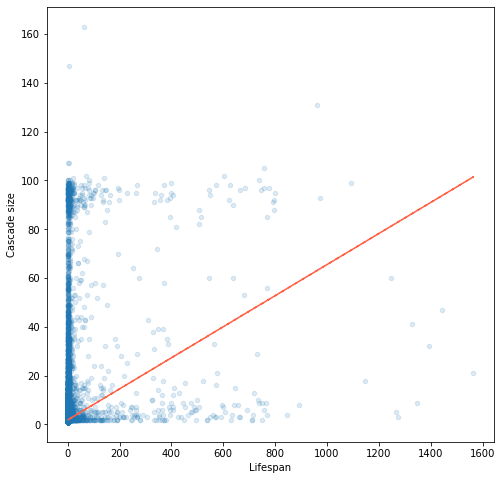

In [21]:
##### lifespan vs cascade size
plt.figure( figsize=(8,8) )
plt.scatter(lifespans, sizes, alpha = 0.15, s = 20)
a, b = np.polyfit(lifespans, sizes, 1)
plt.plot(lifespans, a*lifespans + b, color = "tomato", linewidth = 1.5, linestyle = "--")
plt.xlabel("Lifespan"), plt.ylabel("Cascade size")
plt.show()

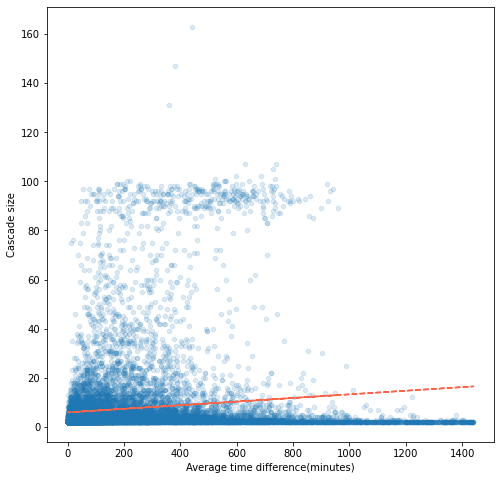

In [11]:
##### average time diff vs cascade size
plt.figure( figsize=(8,8) )
plt.scatter(average_time_diffs[average_time_diffs != -1], sizes[average_time_diffs != -1], alpha = 0.15, s = 20)
a, b = np.polyfit(average_time_diffs[average_time_diffs != -1], sizes[average_time_diffs != -1], 1)
plt.plot(average_time_diffs[average_time_diffs != -1], a*average_time_diffs[average_time_diffs != -1] + b, color = "tomato", linewidth = 1.5, linestyle = "--")
plt.xlabel("Average time difference(minutes)"), plt.ylabel("Cascade size")
plt.show()

In [ ]:


##### first time diff vs cascade size
plt.scatter(first_time_diffs[first_time_diffs != -1], sizes[first_time_diffs != -1], alpha = 0.15, s = 20)

a, b = np.polyfit(first_time_diffs[first_time_diffs != -1], sizes[first_time_diffs != -1], 1)
plt.plot(first_time_diffs[first_time_diffs != -1], a*first_time_diffs[first_time_diffs != -1] + b, color = "tomato", linewidth = 1.5, linestyle = "--")
plt.xlabel("Time difference of first response(minutes)"), plt.ylabel("Cascade size")
plt.show()

##### post datetime distributions
merged_distributions = []
for each_distribution in time_distributions:
    if len(each_distribution) >= 1:
        merged_distributions += each_distribution
plt.hist(merged_distributions, rwidth=0.9)

plt.title("Post Time Distribution (All Cascade)"), plt.xlabel("Time length after source post (minutes)"), plt.ylabel("Post number")
plt.show()

merged_distributions = []
for each_distribution in time_distributions:
    if len(each_distribution) <= 7: # 97.7% of cascade sizes
        merged_distributions += each_distribution
plt.hist(merged_distributions, rwidth=0.9)

plt.title("Post Time Distribution for cascace.size <= 7(bottom 97.7%) )"), plt.xlabel("Time length after source post (minutes)"), plt.ylabel("Post number")
plt.show()

merged_distributions = []
for each_distribution in time_distributions:
    if len(each_distribution) > 7: # top 2.2% of cascade sizes
        merged_distributions += each_distribution
plt.hist(merged_distributions, rwidth=0.9)

plt.title("Post Time Distribution for Cascace.size > 7(top 2.2%) )"), plt.xlabel("Time length after source post (minutes)"), plt.ylabel("Post number")
plt.show()